In [1]:
import os
import sys
import spacy
import pickle
import warnings
import numpy as np 
import tensorflow as tf
from tensorflow import keras
from collections import Counter
from typing import Union, Callable
from tensorflow.keras.models import Sequential
warnings.filterwarnings("ignore")

sys.path.append('..\\src')

from data_saving import DataSaving
from data_loading import DataLoading
from data_processing import DataProcessing
from data_augmentation import DataAugmentation
from data_visualization import DataVisualization
from model_training import ModelTraining
from text_preprocessing import TextPreprocessing
from named_entity_recognition import NamedEntityRecognition

### Data Preparation

In [2]:
parent_script_dir: str = os.path.dirname(os.getcwd())
config_path: str = os.path.join(parent_script_dir, 'config.json')
config: dict[str, any] = DataLoading.load_config(config_path)
intents_path: str = os.path.join(parent_script_dir, config['paths']['intents'])
intents: dict[str, list[str]] = DataLoading.load_intents(intents_path)

training_utterances: list[str] = DataProcessing.get_training_utterances(intents)
training_labels: list[str] = DataProcessing.get_training_labels(intents)
labels: list[str] = DataProcessing.get_labels(intents)
label_counts: Counter = Counter(training_labels)

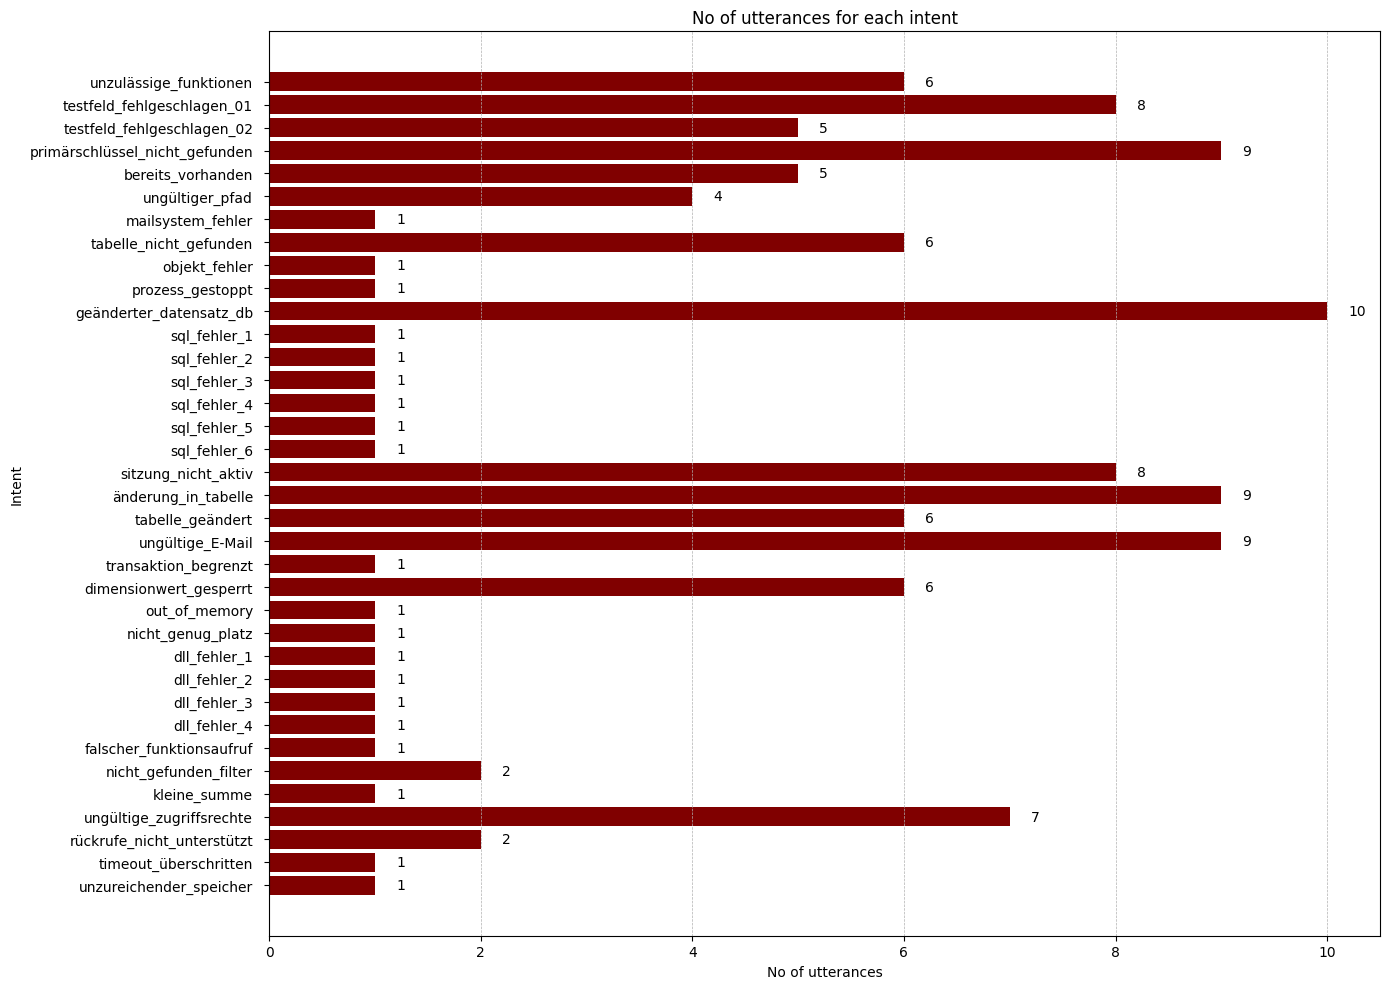

In [3]:
DataVisualization = DataVisualization()
DataVisualization.plot_counter(label_counts)

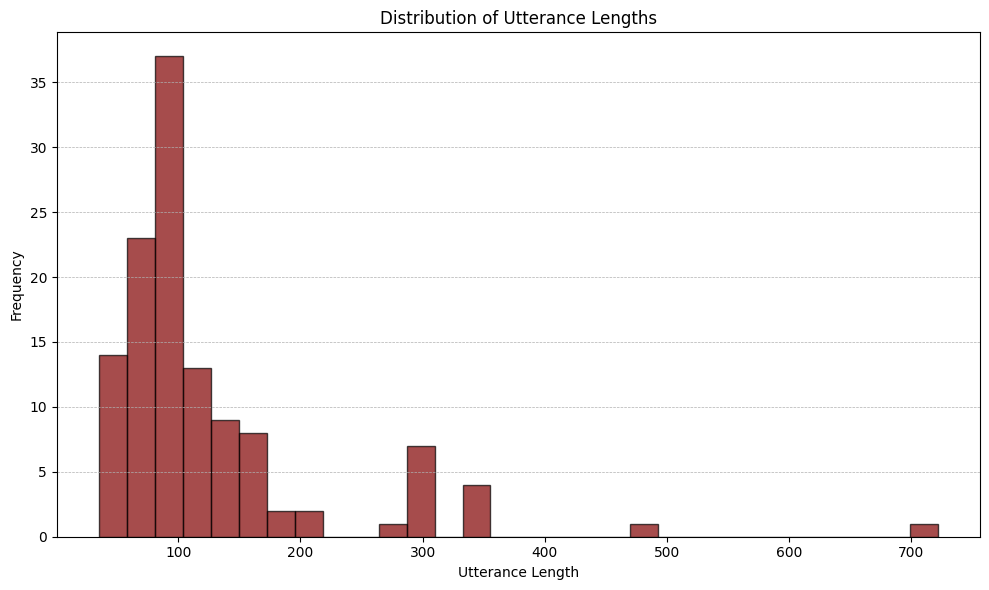

In [4]:
DataVisualization.plot_utterances_length(training_utterances)

#### Data Augmentation

In [ ]:
data_augmentation = DataAugmentation()

stopwords_path: str = os.path.join(parent_script_dir, config['paths']['stopwords'])
aug_stopwords: list[str] = DataLoading.load_stopwords(stopwords_path)
aug_training_utterances, aug_training_labels = data_augmentation.get_augmented_utterances_labels(training_utterances, training_labels,
                                                                                                label_counts, aug_stopwords, config['data_augmentation']['utterances_length'])

print(aug_training_utterances)
aug_training_utterances: list[str] = [x.replace("=", " ").replace("'", " ") for x in aug_training_utterances]

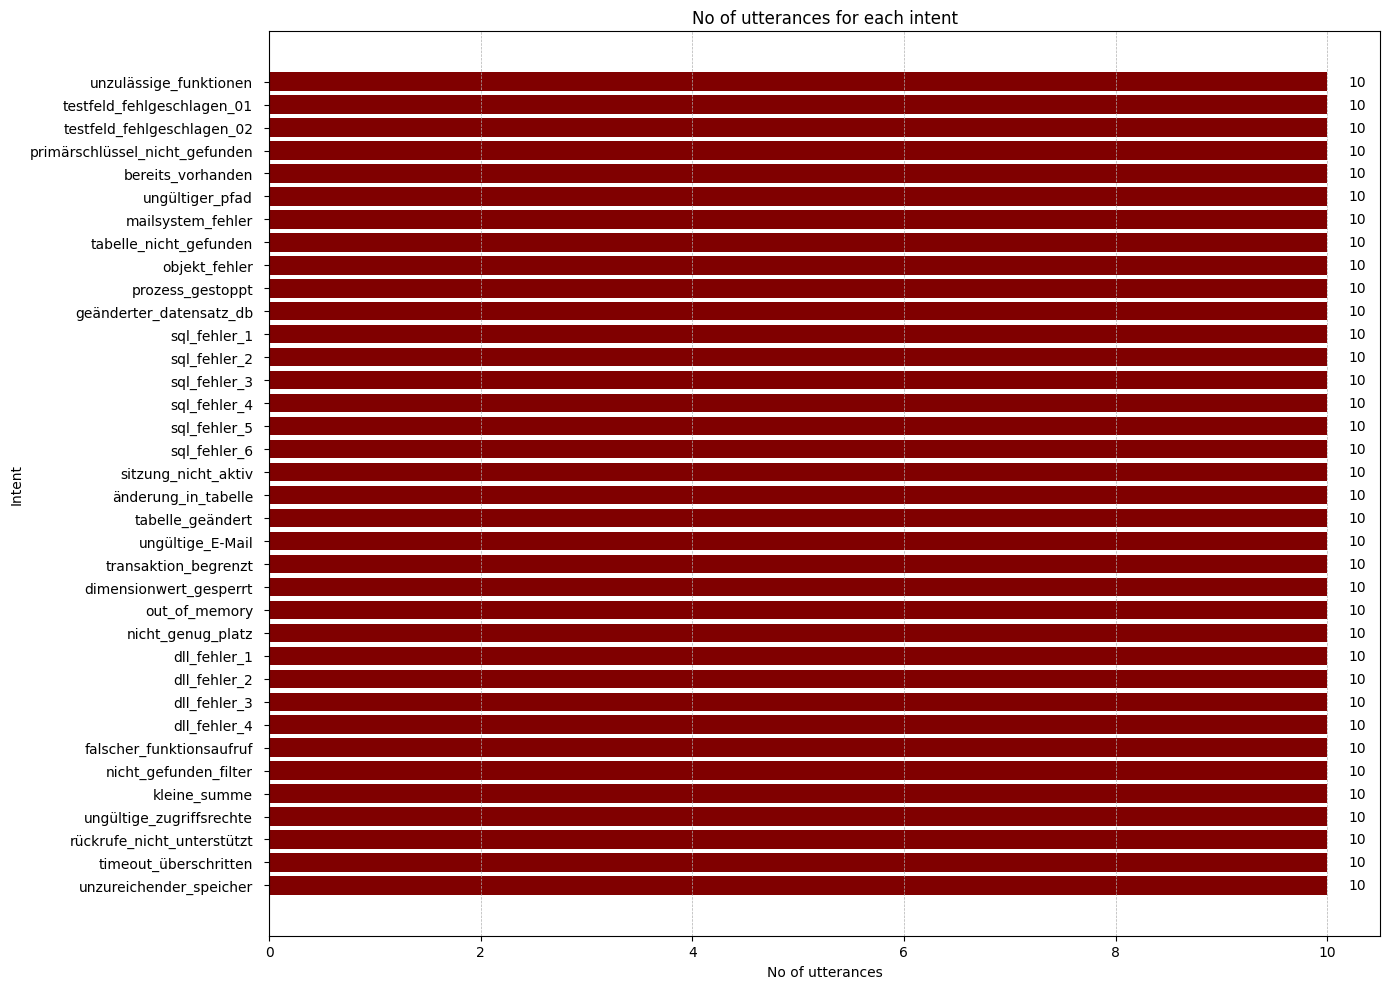

In [6]:
DataVisualization.plot_counter(Counter(aug_training_labels))

### Named Entity Recognition

In [ ]:
entities_path: str = os.path.join(parent_script_dir, config['paths']['entities'])
training_data: list[tuple[str, dict[str, list[tuple[int, int, str]]]]] = NamedEntityRecognition.get_training_data(aug_training_utterances, entities_path, config['spacy']['trained_pipeline'])
training_data

In [ ]:
trained_nlp, training_loss = NamedEntityRecognition.train_ner(training_data, config['ner']['iterations'])

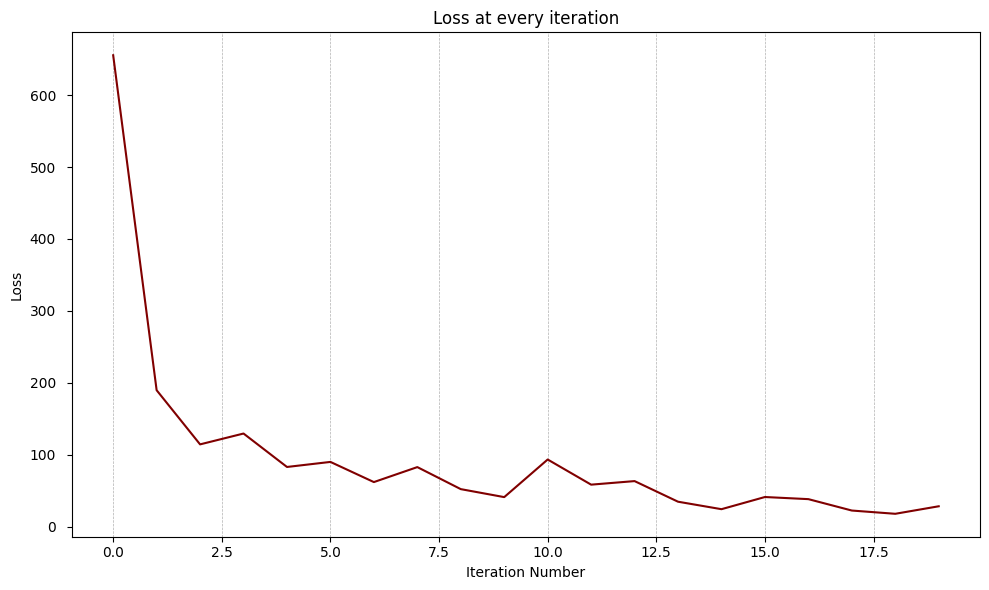

In [9]:
DataVisualization.visualize_loss(training_loss)

In [ ]:
extracted_entities: list[str] = NamedEntityRecognition.extract_entities(aug_training_utterances, trained_nlp, visualize=True)

In [ ]:
aug_training_utterances: list[str] = NamedEntityRecognition.replace_entities(aug_training_utterances, trained_nlp)
aug_training_utterances

### Text Preprocessing

#### Lowercase the text

In [12]:
# Example usage
example_text = "Hallo, WIE GEHT ES DIR?"
lowercased_text = TextPreprocessing.lower_text(example_text)
print(lowercased_text)

hallo, wie geht es dir?


#### Replace abbrevations

In [13]:
contractions_path: str = os.path.join(parent_script_dir, config['paths']['contractions'])
contractions: dict[str, str] = DataLoading.load_contractions(contractions_path)

In [14]:
# Example usage
example_text = "Was machst du heute? ua kommst du ans Meer?"
replaced_text = TextPreprocessing.replace_abbreviations(example_text, contractions)
print(replaced_text)

Was machst du heute? unter andere kommst du an das Meer?


#### Remove unimportant data

In [15]:
# Example usage
example_text = "Dies ist ein Beispieltext. Hier steht ein Link: https://example.com"
cleaned_text = TextPreprocessing.remove_unimportant_data(example_text)
print(cleaned_text)

Dies ist ein Beispieltext  Hier steht ein Link  


#### Remove stopwords

In [16]:
# Example usage
example_text = "Ich bin mit dem Zug zum Bahnhof gefahren"
filtered_text = TextPreprocessing.remove_stopwords(example_text)
print(filtered_text)

Ich Zug Bahnhof gefahren


#### Correct spelling

In [17]:
# Example usage
example_text = "Hllo, wie geth es dir?"
spelling_path: str = os.path.join(parent_script_dir, config['paths']['spelling'])
correct_spelled_text = TextPreprocessing.correct_spelling(example_text, spelling_path)
print(correct_spelled_text)

hallo wie geht es dir


#### Lemmatize text

In [18]:
# Example usage
example_text = "Die Katzen laufen über den grünen Rasen"
lemmatized_text = TextPreprocessing.lemmatize_text(example_text, config['spacy']['trained_pipeline'])
print(lemmatized_text)

der Katze laufen über der grün Rasen


In [ ]:
# preprocessed_training_utterances: list[str] = list(map(lambda utterance: TextPreprocessing.clean_text(utterance, contractions, spelling_path, config['spacy']['trained_pipeline']), aug_training_utterances))
preprocessed_training_utterances: list[str] = []
for i, utterance in enumerate(aug_training_utterances):
    preprocessed_utterance: str = TextPreprocessing.clean_text(utterance, contractions, spelling_path, config['spacy']['trained_pipeline'])
    preprocessed_training_utterances.append(preprocessed_utterance)

    if (i + 1) % 10 == 0 or (i + 1) == len(aug_training_utterances):
        print(f'Processed {i + 1} utterances.')
        
preprocessed_training_utterances

In [46]:
preprocessing_functions: dict[str, Callable[[str], str]] = {
    "lowercase": TextPreprocessing.lower_text,
    "remove_unimportant": TextPreprocessing.remove_unimportant_data,
    "replace_abbreviations": TextPreprocessing.replace_abbreviations,
    "remove_stopwords": TextPreprocessing.remove_stopwords,
    "correct_spelling": TextPreprocessing.correct_spelling,
    "lemmatize": TextPreprocessing.lemmatize_text
}

In [31]:
preprocessed_training_utterances_path: str = os.path.join(parent_script_dir, config['paths']['preprocessed_training_utterances'])

#store preprocessed text on the disk
# with open(preprocessed_training_utterances_path, "wb") as f:
#     pickle.dump(preprocessed_training_utterances, f)

# load preprocessed text from the disk
with open(preprocessed_training_utterances_path, "rb") as f:
    preprocessed_training_utterances = pickle.load(f)

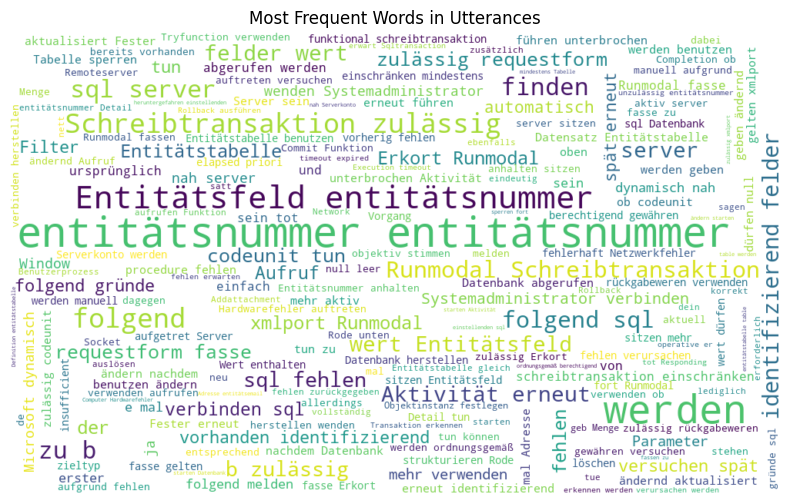

In [32]:
concatenated_training_utterances: str = " ".join(preprocessed_training_utterances)
DataVisualization.plot_wordcloud(concatenated_training_utterances)

#### Encode labels

In [33]:
vocabulary: dict[str, int] = config.get("vocabulary", {})
model: dict[str, Union[int, str, float]] = config.get("model", {})
training: dict[str, int] = config.get("training", {})
model_training = ModelTraining(vocabulary, model, training)

training_labels_encoded: np.ndarray = model_training.get_training_labels_encoded(aug_training_labels)
training_labels_encoded

array([33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 26, 26, 26, 26, 26, 26, 26,
       26, 26, 26, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 14, 14, 14, 14,
       14, 14, 14, 14, 14, 14,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 32,
       32, 32, 32, 32, 32, 32, 32, 32, 32,  9,  9,  9,  9,  9,  9,  9,  9,
        9,  9, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 12, 12, 12, 12, 12,
       12, 12, 12, 12, 12, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,  7,  7,
        7,  7,  7,  7,  7,  7,  7,  7, 18, 18, 18, 18, 18, 18, 18, 18, 18,
       18, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 20, 20, 20, 20, 20, 20,
       20, 20, 20, 20, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 22, 22, 22,
       22, 22, 22, 22, 22, 22, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
       17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 35, 35, 35, 35, 35, 35, 35,
       35, 35, 35, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 30, 30, 30, 30,
       30, 30, 30, 30, 30, 30, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29,  1,
        1,  1,  1,  1,  1

#### Vectorize utterances

In [34]:
tf.random.set_seed(42)

vectorized_preprocessed_training_utterances = model_training.get_vectorized_preprocessed_training_utterances(preprocessed_training_utterances)
print(vectorized_preprocessed_training_utterances)

tf.Tensor(
[[ 67  43 232 ...   0   0   0]
 [ 67  43 320 ...   0   0   0]
 [ 67  43 570 ...   0   0   0]
 ...
 [  7 224 276 ...   0   0   0]
 [196   2   2 ...   0   0   0]
 [ 99 337  53 ...   0   0   0]], shape=(360, 250), dtype=int64)


In [35]:
vectorized_preprocessed_training_utterances_path: str = os.path.join(parent_script_dir, config['paths']['vectorized_preprocessed_training_utterances'])

#store preprocessed text on the disk
# with open(vectorized_preprocessed_training_utterances_path, "wb") as f:
#     pickle.dump(vectorized_preprocessed_training_utterances, f)

# load preprocessed text from the disk
with open(vectorized_preprocessed_training_utterances_path, "rb") as f:
    vectorized_preprocessed_training_utterances = pickle.load(f)

### Model Training

#### Model Arhitecture - CNN (Convolutional Neural Networks)

In [ ]:
X: np.ndarray = np.array(preprocessed_training_utterances)
y: np.ndarray = np.array(training_labels_encoded)
num_labels: int = len(labels)

mean_loss, mean_accuracy, cm_avg, classification_report_str = model_training.train_and_evaluate(X, y, training['num_folds'], labels, num_labels)
print(f"Mean Loss: {mean_loss}")
print(f"Mean Accuracy: {mean_accuracy}")

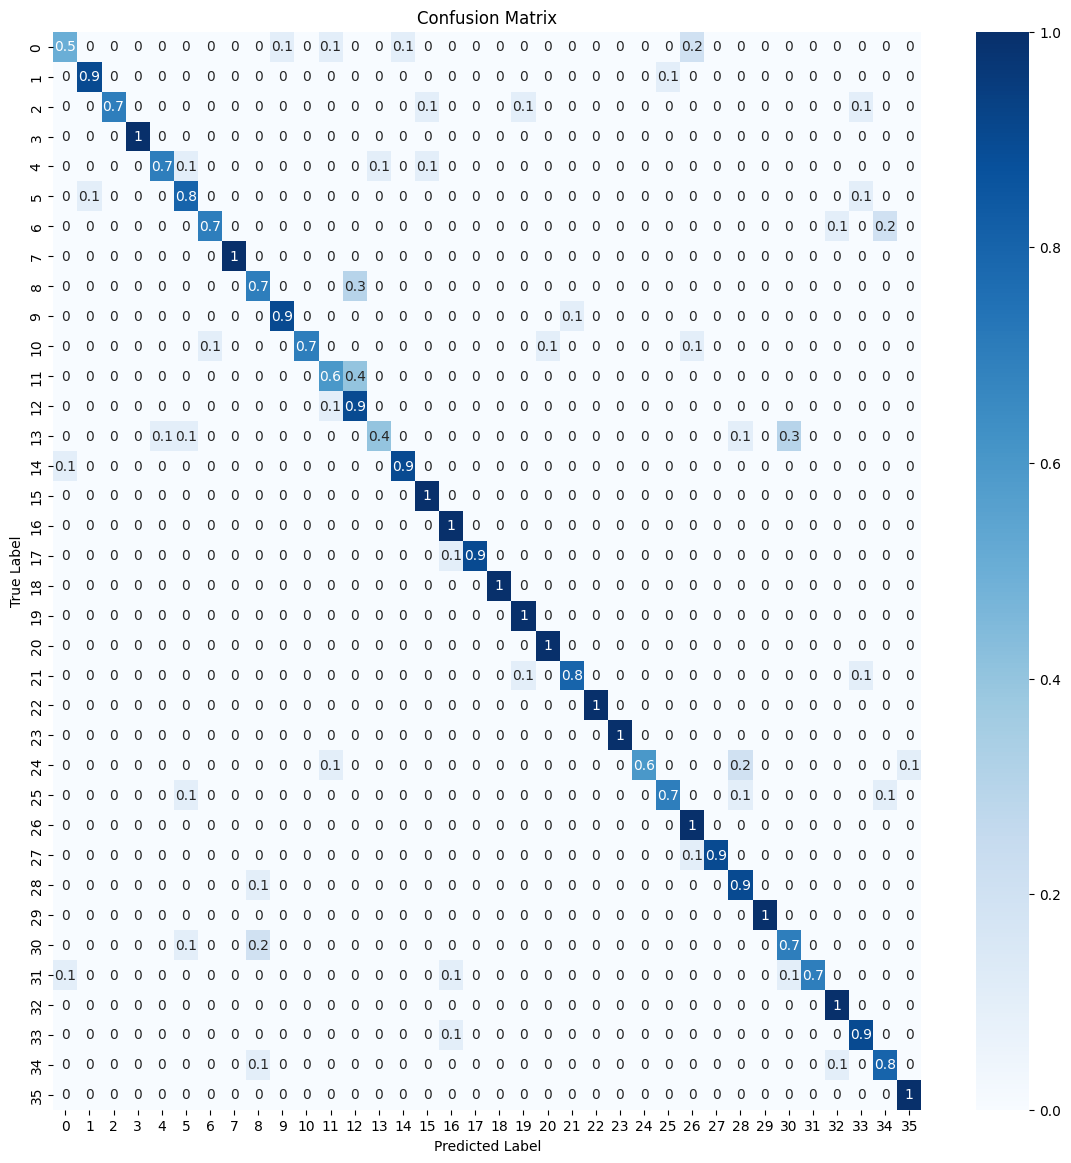

In [37]:
DataVisualization.plot_confusion_matrix(cm_avg)

In [38]:
print(classification_report_str)

                                precision    recall  f1-score   support

        unzulässige_funktionen       0.71      0.50      0.59        10
    testfeld_fehlgeschlagen_01       0.90      0.90      0.90        10
    testfeld_fehlgeschlagen_02       1.00      0.70      0.82        10
primärschlüssel_nicht_gefunden       1.00      1.00      1.00        10
             bereits_vorhanden       0.88      0.70      0.78        10
               ungültiger_pfad       0.67      0.80      0.73        10
             mailsystem_fehler       0.88      0.70      0.78        10
        tabelle_nicht_gefunden       1.00      1.00      1.00        10
                 objekt_fehler       0.64      0.70      0.67        10
              prozess_gestoppt       0.90      0.90      0.90        10
       geänderter_datensatz_db       1.00      0.70      0.82        10
                  sql_fehler_1       0.67      0.60      0.63        10
                  sql_fehler_2       0.56      0.90      0.69  

In [39]:
model: Sequential = model_training.get_model(num_labels)
print(model.summary())

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, None, 128)         640000    
                                                                 
 conv1d_22 (Conv1D)          (None, None, 128)         82048     
                                                                 
 max_pooling1d_22 (MaxPoolin  (None, None, 128)        0         
 g1D)                                                            
                                                                 
 conv1d_23 (Conv1D)          (None, None, 256)         164096    
                                                                 
 max_pooling1d_23 (MaxPoolin  (None, None, 256)        0         
 g1D)                                                            
                                                                 
 global_max_pooling1d_11 (Gl  (None, 256)            

In [40]:
history: keras.callbacks.History = model.fit(vectorized_preprocessed_training_utterances, 
                                             tf.convert_to_tensor(training_labels_encoded), epochs=training['epochs'])

Epoch 1/30
12/12 [==============================] - 3s 56ms/step - loss: 3.5853 - accuracy: 0.0194
Epoch 2/30
12/12 [==============================] - 1s 54ms/step - loss: 3.5428 - accuracy: 0.0500
Epoch 3/30
12/12 [==============================] - 1s 49ms/step - loss: 3.4460 - accuracy: 0.0389
Epoch 4/30
12/12 [==============================] - 1s 54ms/step - loss: 3.3188 - accuracy: 0.0556
Epoch 5/30
12/12 [==============================] - 1s 55ms/step - loss: 3.2140 - accuracy: 0.1306
Epoch 6/30
12/12 [==============================] - 1s 51ms/step - loss: 3.0886 - accuracy: 0.1333
Epoch 7/30
12/12 [==============================] - 1s 53ms/step - loss: 2.8692 - accuracy: 0.1472
Epoch 8/30
12/12 [==============================] - 1s 51ms/step - loss: 2.5547 - accuracy: 0.2611
Epoch 9/30
12/12 [==============================] - 1s 60ms/step - loss: 2.2189 - accuracy: 0.3194
Epoch 10/30
12/12 [==============================] - 1s 51ms/step - loss: 1.8330 - accuracy: 0.4694
Epoch 11/

In [ ]:
print(model_training.vectorize_layer.get_config())
print(model_training.vectorize_layer.get_weights())

#### Save Data

In [44]:
nlp_path: str = os.path.join(parent_script_dir, config['paths']['nlp'])
model_path: str = os.path.join(parent_script_dir, config['paths']['model'])
vectorizer_path: str = os.path.join(parent_script_dir, config['paths']['vectorizer'])
label_encoder_path: str = os.path.join(parent_script_dir, config['paths']['label_encoder'])
preprocessing_functions_path: str = os.path.join(parent_script_dir, config['paths']['preprocessing_functions'])                              

In [47]:
DataSaving.save_trained_nlp(trained_nlp, nlp_path)
DataSaving.save_keras_model(model, model_path)
DataSaving.save_vectorizer(model_training.vectorize_layer, vectorizer_path)
DataSaving.save_label_encoder(model_training.label_encoder, label_encoder_path)
DataSaving.save_preprocessing_functions(preprocessing_functions, preprocessing_functions_path)